In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_datasets as tfds

In [ ]:
(train_dataset, validation_dataset, test_dataset), metadata = tfds.load(
    'horses_or_humans',
    split=['train[:80%]','train[80%:]', 'test'], 
    with_info=True, 
    as_supervised=True,
)



In [ ]:
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 3
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = train_dataset.map(format_example)
validation = validation_dataset.map(format_example)
test = test_dataset.map(format_example)

BATCH_SIZE = 32
shuffle_batch = 1000
train_batches = train.shuffle(shuffle_batch).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

Using MobileNetV2 for improving accuracy

*   model size 14MB
*   Parameters 3,538,984
*   Depth 88
*   Top-1 accuracy - 0.71
*   Top-5 accuracy - 0.90

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (160,160,3),
                                               include_top = False,
                                               weights = 'imagenet')

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
model = tf.keras.Sequential([
       base_model,
       global_average_layer,
       prediction_layer                      
])

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=0, verbose=1 )

history = model.fit(train_batches, epochs = 10, callbacks=[stop_early], validation_data = validation_batches)

Epoch 1/10
26/26 [==============================] - 3s 114ms/step - loss: 0.7894 - accuracy: 0.4927 - val_loss: 0.7069 - val_accuracy: 0.5463
Epoch 2/10
26/26 [==============================] - 2s 75ms/step - loss: 0.6645 - accuracy: 0.5815 - val_loss: 0.6077 - val_accuracy: 0.6195
Epoch 3/10
26/26 [==============================] - 2s 74ms/step - loss: 0.5761 - accuracy: 0.6545 - val_loss: 0.5310 - val_accuracy: 0.7268
Epoch 4/10
26/26 [==============================] - 2s 74ms/step - loss: 0.5029 - accuracy: 0.7336 - val_loss: 0.4700 - val_accuracy: 0.7951
Epoch 5/10
26/26 [==============================] - 2s 74ms/step - loss: 0.4422 - accuracy: 0.7798 - val_loss: 0.4132 - val_accuracy: 0.8244
Epoch 6/10
26/26 [==============================] - 2s 75ms/step - loss: 0.3914 - accuracy: 0.8285 - val_loss: 0.3656 - val_accuracy: 0.8537
Epoch 7/10
26/26 [==============================] - 2s 74ms/step - loss: 0.3494 - accuracy: 0.8601 - val_loss: 0.3271 - val_accuracy: 0.9073
Epoch 8/10
2

In [ ]:
loss,accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 74ms/step - loss: 0.3557 - accuracy: 0.9219
Test accuracy : 0.921875


Test accuracy achieved without any finetuning : 92.18%

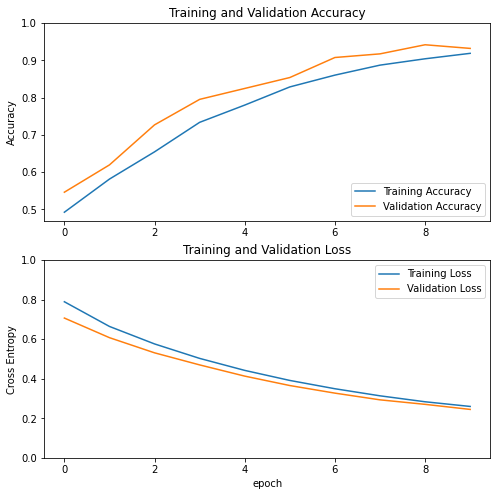

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Fine Tuning


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.0001/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [ ]:
len(model.trainable_variables)

58

In [ ]:
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs


history_fine = model.fit(train_batches, epochs = total_epochs, callbacks=[stop_early], initial_epoch=history.epoch[-1], validation_data = validation_batches)

Epoch 10/20
26/26 [==============================] - 3s 120ms/step - loss: 0.3496 - accuracy: 0.8613 - val_loss: 0.1591 - val_accuracy: 0.9512
Epoch 11/20
26/26 [==============================] - 2s 90ms/step - loss: 0.1789 - accuracy: 0.9708 - val_loss: 0.1248 - val_accuracy: 0.9561
Epoch 12/20
26/26 [==============================] - 2s 87ms/step - loss: 0.1105 - accuracy: 0.9842 - val_loss: 0.1007 - val_accuracy: 0.9707
Epoch 13/20
26/26 [==============================] - 2s 88ms/step - loss: 0.0599 - accuracy: 0.9964 - val_loss: 0.0828 - val_accuracy: 0.9756
Epoch 14/20
26/26 [==============================] - 2s 87ms/step - loss: 0.0388 - accuracy: 0.9976 - val_loss: 0.0691 - val_accuracy: 0.9902
Epoch 15/20
26/26 [==============================] - 2s 87ms/step - loss: 0.0308 - accuracy: 0.9976 - val_loss: 0.0584 - val_accuracy: 0.9902
Epoch 00015: early stopping


In [ ]:
loss_,accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 74ms/step - loss: 0.1138 - accuracy: 0.9648
Test accuracy : 0.96484375


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

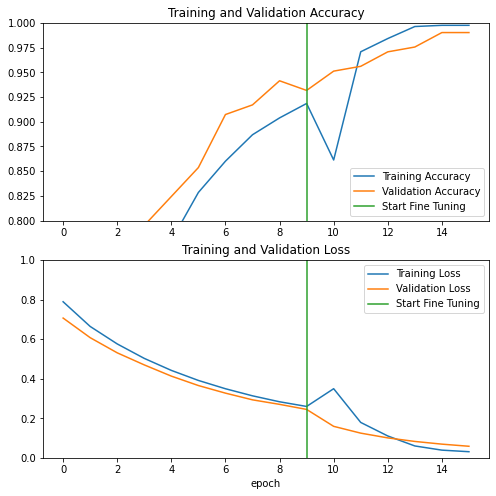

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

After epoch 9, last 58 layers of the base model was finetuned to achive better accuracy for the Horse or humans dataset.

the accuracy achieved after fine tuning is 96.48 %
which is 4.3% accuracy increase to the baseline model accuracy.